# HetRec 2011
---
The 2nd International Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec 2011, http://ir.ii.uam.es/hetrec2011) has released datasets from Delicious, Last.fm Web 2.0, MovieLens, IMDb, and Rotten Tomatoes. These datasets contain social networking, tagging, and resource consuming (Web page bookmarking and music artist listening) information from sets of around 2,000 users.

The datasets were generated by the Information Retrieval Group at Universidad Autónoma de Madrid (http://ir.ii.uam.es). Before using these datasets, please review the README files for the usage license and other details.

---
**MOVIES RECOMMENDER SYSTEM**

In [1]:
import numpy as np
import pandas as pd

import csv
import os

from tqdm.notebook import tqdm

from scipy.spatial.distance import cdist

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn

import fasttext
import fasttext.util

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Data loading & correction
---

In [2]:
def dat_to_csv(dat_file, has_header=True, delimiter=',', save=False):
    with open(dat_file, 'r', encoding='cp437') as f:
        lines = f.read().split('\n')[:-1]
    
    if has_header:
        columns = lines[0].split(delimiter)
        lines = lines[1:]
    else:
        columns = [f'Column {i}' for i in range(len(lines[0].split(delimiter)))]
    
    df = pd.DataFrame(np.array([l.split(delimiter) for l in lines]), columns=columns)
    if save:
        df.to_csv(dat_file.replace('.dat', '.csv'))
    
    return df

## MovieLens + IMDb/Rotten Tomatoes dataset

In [3]:
df_ml_movies = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movies.dat', delimiter='\t')
df_ml_tags = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/tags.dat', delimiter='\t')
df_ml_moviegenres = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movie_genres.dat', delimiter='\t')
df_ml_usertagged = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_taggedmovies-timestamps.dat', delimiter='\t')
df_ml_userrated = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_ratedmovies-timestamps.dat', delimiter='\t')

In [4]:
df_ml_movies = df_ml_movies[['id', 'title']]
df_ml_movies.head()

,id,title
0,1,Toy story
1,2,Jumanji
2,3,Grumpy Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [5]:
df_ml_tags.head()

,id,value
0,1,earth
1,2,police
2,3,boxing
3,4,painter
4,5,whale


In [6]:
df_ml_moviegenres.head()

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [7]:
df_ml_usertagged = df_ml_usertagged[['userID', 'movieID', 'tagID']]
df_ml_usertagged.head()

,userID,movieID,tagID
0,75,353,5290
1,78,4223,5264
2,127,1343,1544
3,127,1343,12330
4,127,2080,1451


In [8]:
df_ml_userrated = df_ml_userrated[['userID', 'movieID', 'rating']]
df_ml_userrated.head()

,userID,movieID,rating
0,75,3,1
1,75,32,4.5
2,75,110,4
3,75,160,2
4,75,163,4


In [9]:
print(f'Movies: {len(df_ml_movies)}')
print(f'Tags: {len(df_ml_tags)}')
print(f'Genres: {len(df_ml_moviegenres)}')
print(f'Movies user taggings: {len(df_ml_usertagged)}')
print(f'Movies user ratings: {len(df_ml_userrated)}')

Movies: 10197
Tags: 13222
Genres: 20809
Movies user taggings: 47957
Movies user ratings: 855598


## Movies and users ids correction

First change indices data type from 'str' appropriately to 'np.int32' or 'np.float32'.

In [10]:
df_ml_userrated['userID'] = df_ml_userrated['userID'].astype(np.int32)
df_ml_userrated['movieID'] = df_ml_userrated['movieID'].astype(np.int32)
df_ml_userrated['rating'] = df_ml_userrated['rating'].astype(np.float32)

df_ml_usertagged['userID'] = df_ml_usertagged['userID'].astype(np.int32)
df_ml_usertagged['movieID'] = df_ml_usertagged['movieID'].astype(np.int32)
df_ml_usertagged['tagID'] = df_ml_usertagged['tagID'].astype(np.int32)

df_ml_movies['id'] = df_ml_movies['id'].astype(np.int32)

df_ml_tags['id'] = df_ml_tags['id'].astype(np.int32)

df_ml_moviegenres['movieID'] = df_ml_moviegenres['movieID'].astype(np.int32)

In [11]:
users = df_ml_userrated['userID'].values
items = df_ml_userrated['movieID'].values
ui_ratings = df_ml_userrated['rating'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Ratings: {len(ui_ratings)}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 2113
Items: 10109
Ratings: 855598
Max user_id: 71534
Max item_id: 65133


Maximum user index 71534 and item index 65133 are out of range: 2113 and 10109. Need to reset indices for rating prediction task.

In [12]:
user_mapping = dict(zip(np.unique(users), np.arange(n_users)))
item_mapping = dict(zip(np.unique(items), np.arange(n_items)))

In [13]:
user_rev_mapping = dict({v: k for k, v in user_mapping.items()})
item_rev_mapping = dict({v: k for k, v in item_mapping.items()})

In [14]:
df_ml_userrated['fixed_userID'] = df_ml_userrated['userID'].replace(user_mapping)
df_ml_userrated['fixed_movieID'] = df_ml_userrated['movieID'].replace(item_mapping)

In [15]:
users = df_ml_userrated['fixed_userID'].values
items = df_ml_userrated['fixed_movieID'].values
ui_ratings = df_ml_userrated['rating'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 2113
Items: 10109
Max user_id: 2112
Max item_id: 10108


Now it's ok.

# Movies recommendation
---
Aspects according to given user id:
- predicted movie ratings for user (matrix factorization / deep learning)
- movie genres similarity (content based approach)
- movie titles similarity (content based approach)
- movie user tagging similarity (collaborative filtering approach)
---
Let's perform movies recommendation for users 190 (new **5**) and 622 (new **17**).

In [16]:
USER01 = 190
USER02 = 622

print(f'User {USER01} --> rating user: {user_mapping[USER01]}')
print(f'User {USER02} --> rating user: {user_mapping[USER02]}')

User 190 --> rating user: 5
User 622 --> rating user: 17


## Rating - Dense Feedforward NN

In [17]:
def user_ratings(user_id):
    df_common = df_ml_userrated.merge(df_ml_movies, left_on='movieID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['movieID', 'title', 'rating']]\
    .sort_values('rating', ascending=False)

In [18]:
df_user01_ratings = user_ratings(USER01)
df_user01_ratings

,movieID,title,rating
74611,1196,Star Wars: Episode V - The Empire Strikes Back,5.0
350080,8368,Harry Potter and the Prisoner of Azkaban,5.0
29127,5952,The Lord of the Rings: The Two Towers,5.0
27376,4993,The Lord of the Rings: The Fellowship of the Ring,5.0
25417,3793,X-Men,5.0
...,...,...,...
331620,4148,Hannibal,0.5
322834,2915,Risky Business,0.5
4664,296,Pulp Fiction,0.5
262589,593,The Silence of the Lambs,0.5


In [19]:
df_user02_ratings = user_ratings(USER02)
df_user02_ratings

,movieID,title,rating
263,32,Twelve Monkeys,5.0
214788,47,Shichinin no samurai,5.0
244325,4963,Ocean's Eleven,5.0
239900,4011,Snatch.,5.0
551652,54745,Rocket Science,5.0
...,...,...,...
240838,4306,Shrek,3.5
615471,688,Operation Dumbo Drop,3.0
615274,546,Super Mario Bros.,3.0
418172,54997,3:10 to Yuma,2.0


### Helpers

In [20]:
def batch(l, size):
    for i in range(0, len(l), size):
        yield l[i:i+size]

### Model

In [21]:
class DenseNet(torch.nn.Module):

    def __init__(self, n_users, n_items, n_factors, H1, D_out):
        """
        Simple Feedforward with Embeddings
        """
        super().__init__()
        # user and item embedding layers
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)
        # dropout after embeddings
        self.dropout1 = torch.nn.Dropout(0.1)
        # linear layers
        self.linear1 = torch.nn.Linear(n_factors*2, H1)
        self.linear2 = torch.nn.Linear(H1, H1)
        self.linear3 = torch.nn.Linear(H1, H1)
        self.linear4 = torch.nn.Linear(H1, D_out)
        # dropout after linear layers
        self.dropout2 = torch.nn.Dropout(0.1)

    def forward(self, users, items):
        users_embedding = self.user_factors(users)
        items_embedding = self.item_factors(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([users_embedding, items_embedding], 1)
        x = self.dropout1(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.dropout2(self.linear4(x))
        output_scores = torch.sigmoid(x)*5
        
        return output_scores

    def predict(self, users, items):
        # return the score
        output_scores = self.forward(users, items)
        return output_scores

In [22]:
class RatingPredictor():
    
    def __init__(self, user_ids, item_ids, ui_ratings, n_factors, h1):
        """
        Movie ratings predictor for all users.
        """
        self.user_ids = user_ids
        self.item_ids = item_ids
        
        self.ui_ratings = ui_ratings
        self.n_users = np.size(np.unique(user_ids))
        self.n_items = np.size(np.unique(item_ids))
        
        self.n_factors = n_factors
        self.h1 = h1
        
        self.__model = DenseNet(self.n_users, self.n_items, n_factors=self.n_factors, H1=self.h1, D_out=1)
        self.__loss = torch.nn.MarginRankingLoss()
        self.__optim = torch.optim.SGD(self.__model.parameters(), lr=1e-6)
        
    
    def fit(self, epochs, batch_size, save_progress=False):
        if save_progress:
            with open(f'hetrec2011/mr_prog_{self.n_factors}f_{self.h1}h.csv', 'w') as f:
                csv.writer(f).writerow(['epoch loss'])
        
        t = tqdm(range(epochs))
        for epoch in t:
            t.set_postfix_str(f'Epoch {epoch + 1}/{epochs}')
            us_b = batch(self.user_ids, size=batch_size)
            is_b = batch(self.item_ids, size=batch_size)
            uirs_b = batch(self.ui_ratings, size=batch_size)
            epoch_loss = 0
            
            tt = tqdm(zip(us_b, is_b, uirs_b),
                      total=int(np.size(self.ui_ratings)/batch_size + 1), leave=False)
            for u, i, uir in tt:
                # get user, item and rating data batch
                user = Variable(torch.LongTensor(u))
                item = Variable(torch.LongTensor(i))
                rating = Variable(torch.FloatTensor(uir))

                # predict
                prediction = self.__model(user, item)
                target = (prediction.reshape(-1) <= rating).int() - (prediction.reshape(-1) > rating).int()
                loss = self.__loss(prediction.reshape(-1), rating, target)
                epoch_loss += loss.detach().numpy()
                tt.set_postfix_str(f'Current MR loss: {np.round(np.float64(loss.detach().numpy()), 4)} ' +
                                   f'| Total: {np.round(epoch_loss, 4)}')

                # backpropagate
                loss.backward()

                # update weights
                self.__optim.step()
            
            #save current movie-rating progress step
            if save_progress:
                with open(f'hetrec2011/mr_prog_{self.n_factors}f_{self.h1}h.csv', 'a+') as f:
                    csv.writer(f).writerow([epoch_loss])
    
    def predict(self, user_id):
        user_id = user_mapping[user_id]
        users_tensor = torch.tensor([user_id]*np.size(self.item_ids))
        items_tensor = torch.tensor(self.item_ids)
        return self.__model(users_tensor, items_tensor).flatten().detach().numpy()

### Tests

In [23]:
BATCH_SIZE = 64
EPOCHS = 1

In [24]:
INPUT_FACTORS = 20
HIDDEN_FACTORS = 60

In [25]:
RP_MODEL_PATH = f'hetrec2011/rp_model_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h'

In [26]:
df_userrated_titles = df_ml_userrated.merge(df_ml_movies, left_on='movieID', right_on='id')
df_userrated_titles

,userID,movieID,rating,fixed_userID,fixed_movieID,id,title
0,75,3,1.0,0,2,3,Grumpy Old Men
1,783,3,2.0,22,2,3,Grumpy Old Men
2,788,3,3.5,23,2,3,Grumpy Old Men
3,1160,3,4.0,33,2,3,Grumpy Old Men
4,1174,3,2.5,35,2,3,Grumpy Old Men
...,...,...,...,...,...,...,...
855593,71331,62796,3.0,2103,9998,62796,Fifty Pills
855594,71420,3585,4.0,2104,3285,3585,The Great Locomotive Chase
855595,71420,59065,1.5,2104,9763,59065,Chapter 27
855596,71483,4421,2.5,2106,4094,4421,Blackout


In [27]:
if not os.path.exists(RP_MODEL_PATH):
    rp = RatingPredictor(
        df_userrated_titles['fixed_userID'].values,
        df_userrated_titles['fixed_movieID'].values,
        df_userrated_titles['rating'].values,
        n_factors=INPUT_FACTORS, h1=HIDDEN_FACTORS)
    rp.fit(epochs=EPOCHS, batch_size=BATCH_SIZE, save_progress=True)
    torch.save(rp, RP_MODEL_PATH)
else:
    rp = torch.load(RP_MODEL_PATH)

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type DenseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [28]:
def prediction_quality_plot(input_file, title, save_file=None):
    df = pd.read_csv(input_file)
    
    plt.plot(df.index + 1, df['epoch loss'], label='epoch margin ranking loss')
    plt.scatter(df.index + 1, df['epoch loss'])
    plt.xticks(df.index + 1)
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    for k, v in zip(df.index + 1, df['epoch loss']):
        plt.annotate(np.round(v, 4), (k, v), size=16, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(loc='best')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

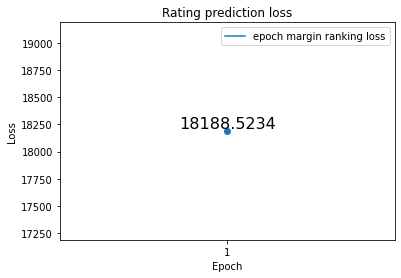

In [29]:
prediction_quality_plot(input_file=f'hetrec2011/mr_prog_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.csv',
                        title='Rating prediction loss',
                        save_file=f'hetrec2011/rating_prediction_loss_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.png')

In [30]:
def ratings_recommendations(df, predictions):
    df_all = pd.DataFrame({
        'movieID': df['movieID'].values,
        'title': df['title'].values,
        'pred. rating': predictions
    }).drop_duplicates()
    
    df_all = df_all.groupby(['movieID', 'title'])['pred. rating'].apply(np.max).to_frame().reset_index()
    
    return df_all.sort_values('pred. rating', ascending=False)

In [31]:
df_user01_ratings_recommendations = ratings_recommendations(df_userrated_titles, rp.predict(USER01))
df_user01_ratings_recommendations

,movieID,title,pred. rating
5675,6058,Final Destination 2,4.113505
3863,4184,The Bishop's Wife,4.113120
1114,1234,The Sting,4.113036
9808,59731,Bigger Stronger Faster*,4.112523
2487,2726,The Killing,4.112491
...,...,...,...
9338,50970,Myra Breckinridge,2.500000
3680,3995,Boys Life 3,2.500000
8915,41336,Nazarφn,2.500000
3620,3934,Kronos,2.500000


In [32]:
df_user02_ratings_recommendations = ratings_recommendations(df_userrated_titles, rp.predict(USER02))
df_user02_ratings_recommendations

,movieID,title,pred. rating
5094,5446,Rabbit-Proof Fence,4.111625
9692,57669,In Bruges,4.101867
3211,3504,Network,4.098352
8235,26985,Nirvana,4.096557
1738,1953,The French Connection,4.096217
...,...,...,...
4797,5138,State Property,2.500000
10047,63772,Bullfighter and the Lady,2.500000
6081,6490,Manito,2.500000
1305,1444,Guantanamera,2.500000


## Genres - Content Based Approach

Each movie has a list of assigned genres. Task is to calculate Jaccard similarity for each movie to each i.e. to construct Jaccard similarity matrix.

In [33]:
genres = np.unique(df_ml_moviegenres['genre'])
genres

array(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Thriller',
       'War', 'Western'], dtype=object)

In [34]:
# first aggregate (to numpy array) movie genres dataframe by movieID
srs_moviegenres = df_ml_moviegenres.groupby('movieID')['genre'].apply(np.array).values
srs_moviegenres

array([array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
      dtype=object),
       array(['Adventure', 'Children', 'Fantasy'], dtype=object),
       array(['Comedy', 'Romance'], dtype=object), ...,
       array(['Comedy', 'Drama'], dtype=object),
       array(['Drama', 'Romance'], dtype=object),
       array(['Comedy'], dtype=object)], dtype=object)

In [35]:
# build zero-one genres dataframe
df_moviegenres_zeroone = pd.DataFrame([{g: 1 if g in mgs else 0 for g in genres} for mgs in srs_moviegenres])
df_moviegenres_zeroone

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Short,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10193,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
10194,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10195,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [36]:
jaccard_mtx = cdist(df_moviegenres_zeroone, df_moviegenres_zeroone, 'jaccard')
jaccard_mtx = np.subtract(np.ones(jaccard_mtx.shape), jaccard_mtx)

df_jaccard_sim = pd.DataFrame(jaccard_mtx,
                              index=df_ml_movies['id'].values,
                              columns=df_ml_movies['id'].values)
df_jaccard_sim

,1,2,3,4,5,6,7,8,9,10,...,64997,64999,65006,65011,65037,65088,65091,65126,65130,65133
1,1.000000,0.6,0.166667,0.142857,0.200000,0.0,0.166667,0.400000,0.0,0.142857,...,0.0,0.0,0.0,0.166667,0.000000,0.600000,0.000000,0.166667,0.000000,0.200000
2,0.600000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.0,0.200000,...,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
3,0.166667,0.0,1.000000,0.666667,0.500000,0.0,1.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.333333,0.000000,0.250000,0.250000,0.333333,0.333333,0.500000
4,0.142857,0.0,0.666667,1.000000,0.333333,0.0,0.666667,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.666667,0.333333,0.200000,0.500000,0.666667,0.666667,0.333333
5,0.200000,0.0,0.500000,0.333333,1.000000,0.0,0.500000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.500000,0.000000,0.333333,0.000000,0.500000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65088,0.600000,0.5,0.250000,0.200000,0.333333,0.0,0.250000,0.666667,0.0,0.200000,...,0.0,0.0,0.0,0.250000,0.000000,1.000000,0.000000,0.250000,0.000000,0.333333
65091,0.000000,0.0,0.250000,0.500000,0.000000,0.2,0.250000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.250000,0.333333,0.000000,1.000000,0.250000,0.666667,0.000000
65126,0.166667,0.0,0.333333,0.666667,0.500000,0.0,0.333333,0.000000,0.0,0.000000,...,0.0,0.0,0.0,1.000000,0.500000,0.250000,0.250000,1.000000,0.333333,0.500000
65130,0.000000,0.0,0.333333,0.666667,0.000000,0.0,0.333333,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.333333,0.500000,0.000000,0.666667,0.333333,1.000000,0.000000


In [37]:
N_HIGHEST = 10

Take **N_HIGHEST** user movie ratings and then for each taken movie calculate jaccards similarities. Stack them vertically and calculate summaric similarity aggregating by 'movieID'.

In [61]:
def users_genres_most_similar(df, n_highest=N_HIGHEST):
    df_highest = df[:n_highest][['movieID']]
    
    df_all = pd.DataFrame(columns=df_highest.columns)
    
    for i, row in df_highest.iterrows():
        sims = df_jaccard_sim[int(row['movieID'])].values
        df_sims = pd.DataFrame({
            'movieID': df_jaccard_sim.index,
            's': sims
        })
        
        df_all = pd.concat([df_all, df_sims])
    
    df_all = df_all.groupby('movieID')['s'].apply(np.sum)
    
    df_all = pd.DataFrame({
        'movieID': df_all.index,
        'sum sim.': df_all.values
    })
    
    return df_all.merge(df_ml_movies, left_on='movieID', right_on='id')[['movieID', 'title', 'sum sim.']]\
                 .sort_values('sum sim.', ascending=False)

In [39]:
df_user01_genres_similarities = users_genres_most_similar(df_user01_ratings)
df_user01_genres_similarities

,movieID,title,sum sim.
8342,27608,Immortel (ad vitam),6.05
9174,46530,Superman Returns,6.05
2417,2641,Superman II,6.05
6973,7373,Hellboy,6.05
5139,5463,Reign of Fire,6.05
...,...,...,...
7165,7781,Twister,0.00
2838,3077,42: Forty Two Up,0.00
2837,3076,Irma la Douce,0.00
7170,7786,Genghis Blues,0.00


In [40]:
df_user02_genres_similarities = users_genres_most_similar(df_user02_ratings)
df_user02_genres_similarities

,movieID,title,sum sim.
582,608,Fargo,4.25
9050,43853,The Business,4.25
3014,3266,C'est arrivΘ prΦs de chez vous,4.25
6112,6486,The Hard Word,4.25
9033,42900,Cul-de-sac,4.25
...,...,...,...
9692,56030,Darfur Now,0.00
7564,8577,Comandante,0.00
5214,5539,Care Bears Movie II: A New Generation,0.00
5213,5538,The Care Bears Movie,0.00


## Titles - Content Based Approach

Each movie has a title. Task is to calculate cosine similarity of vectorized titles.

In [41]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [42]:
titles = df_ml_movies['title'].values
titles_embeddings = np.array([ft_model[t] for t in titles])

In [43]:
del ft_model

In [44]:
cosine_mtx = cdist(titles_embeddings, titles_embeddings, 'cosine')
cosine_mtx = np.subtract(np.ones(cosine_mtx.shape), cosine_mtx)

df_cosine_sim = pd.DataFrame(cosine_mtx,
                             index=df_ml_movies['id'].values,
                             columns=df_ml_movies['id'].values)
df_cosine_sim

,1,2,3,4,5,6,7,8,9,10,...,64997,64999,65006,65011,65037,65088,65091,65126,65130,65133
1,1.000000,-0.043924,0.254355,0.322977,0.068773,-0.043023,0.025546,0.150753,0.139382,0.002632,...,0.180460,0.260140,0.055759,0.282909,0.033936,0.191460,0.212996,-0.056620,0.223498,0.177634
2,-0.043924,1.000000,0.025938,0.105813,0.042646,0.194687,0.194283,0.168683,0.042247,0.329911,...,0.078574,0.099685,0.014848,0.035286,0.026990,0.045645,0.053180,0.183267,0.019522,0.105598
3,0.254355,0.025938,1.000000,0.476239,0.291594,0.102405,0.165065,0.323610,0.258272,0.004917,...,0.418594,0.482253,0.070757,0.438249,-0.028020,0.314664,0.359335,0.025119,0.353919,0.400596
4,0.322977,0.105813,0.476239,1.000000,0.411442,0.189339,0.064835,0.329333,0.363486,0.109441,...,0.432929,0.531393,0.170560,0.506312,0.040599,0.446627,0.419125,0.146824,0.459336,0.443977
5,0.068773,0.042646,0.291594,0.411442,1.000000,0.066673,0.080009,0.327017,0.404592,0.040607,...,0.567281,0.584939,0.077777,0.207039,0.076673,0.367735,0.395918,0.113340,0.266810,0.307080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65088,0.191460,0.045645,0.314664,0.446627,0.367735,0.124570,0.043616,0.199498,0.429269,0.003768,...,0.307136,0.310665,0.094262,0.252204,-0.086122,1.000000,0.224157,0.060827,0.318255,0.203941
65091,0.212996,0.053180,0.359335,0.419125,0.395918,0.154439,0.144422,0.308408,0.195621,0.100803,...,0.311179,0.360876,0.208511,0.296719,0.146770,0.224157,1.000000,0.092238,0.316828,0.443965
65126,-0.056620,0.183267,0.025119,0.146824,0.113340,0.321504,0.083696,0.188321,0.106621,0.179827,...,0.000244,0.048291,0.165039,0.090637,-0.070498,0.060827,0.092238,1.000000,0.054269,0.068604
65130,0.223498,0.019522,0.353919,0.459336,0.266810,0.064338,0.015603,0.329389,0.358824,0.001381,...,0.425379,0.500344,0.114534,0.481372,-0.013896,0.318255,0.316828,0.054269,1.000000,0.464840


Take **N_HIGHEST** user movie ratings and then for each taken movie calculate cosine similarities. Stack them vertically and calculate summaric similarity aggregating by 'movieID'.

In [45]:
def users_titles_most_similar(df, n_highest=N_HIGHEST):
    df_highest = df[:n_highest][['movieID']]
    
    df_all = pd.DataFrame(columns=df_highest.columns)
    
    for i, row in df_highest.iterrows():
        sims = df_cosine_sim[int(row['movieID'])].values
        df_sims = pd.DataFrame({
            'movieID': df_jaccard_sim.index,
            's': sims
        })
        
        df_all = pd.concat([df_all, df_sims])
    
    df_all = df_all.groupby('movieID')['s']\
                   .apply(np.sum)
    
    df_all = pd.DataFrame({
        'movieID': df_all.index,
        'sum sim.': df_all.values
    })
    
    return df_all.merge(df_ml_movies, left_on='movieID', right_on='id')[['movieID', 'title', 'sum sim.']]\
                 .sort_values('sum sim.', ascending=False)

In [46]:
df_user01_titles_similarities = users_titles_most_similar(df_user01_ratings)
df_user01_titles_similarities

,movieID,title,sum sim.
7445,8368,Harry Potter and the Prisoner of Azkaban,5.030590
8959,40815,Harry Potter and the Goblet of Fire,4.937958
5782,6137,Sword of the Valiant: The Legend of Sir Gawain...,4.922795
3895,4192,Demetrius and the Gladiators,4.872219
4460,4769,Into the Arms of Strangers: Stories of the Kin...,4.845430
...,...,...,...
8065,25964,Sh√bun,-0.085004
4227,4531,Red Heat,-0.091027
8352,27674,11:14,-0.145135
3375,3656,Lured,-0.242310


In [47]:
df_user02_titles_similarities = users_titles_most_similar(df_user02_ratings)
df_user02_titles_similarities

,movieID,title,sum sim.
6341,6722,Wong Fei Hung II: Nam yi dong ji keung,5.097365
4460,4769,Into the Arms of Strangers: Stories of the Kin...,5.046495
8658,32582,The Wild Parrots of Telegraph Hill,5.027367
2762,2998,Dreaming of Joseph Lees,5.020711
4537,4846,Siu nin Wong Fei Hung ji: Tit Ma Lau,5.014109
...,...,...,...
4577,4887,The One,-0.149586
6779,7172,Uzak,-0.173995
8065,25964,Sh√bun,-0.215403
8540,31617,El Cid,-0.245391


## User tagging - Collaborative Filtering Approach

Some certain movies have some certain user taggings. Group user tagging by movie and then calculate the mean of cosine similarities for each vectorized tags pair. At the end take maximum movie tagging values (group by movies).

In [48]:
srs_user_taglists = df_ml_usertagged.merge(df_ml_tags, left_on='tagID', right_on='id', how='left')\
                                    .drop(['tagID', 'id'], axis=1).groupby(['userID', 'movieID'])['value']\
                                    .apply(lambda x: ', '.join(np.sort(x)))
srs_uid, srs_mid = np.array([*srs_user_taglists.index]).T
df_user_taglists = pd.DataFrame({
    'userID': srs_uid,
    'movieID': srs_mid,
    'tags': srs_user_taglists.values
})
del srs_uid, srs_mid
df_user_taglists = df_user_taglists.merge(df_ml_movies, left_on='movieID', right_on='id', how='left')\
                                   .drop('id', axis=1)
df_user_taglists[['userID', 'movieID', 'title', 'tags']]  # tags must be ordered ascendingly

,userID,movieID,title,tags
0,75,353,The Crow,tissit
1,78,4223,Enemy at the Gates,want to own
2,127,1343,Cape Fear,"killer, stalker"
3,127,2080,Lady and the Tramp,"dogs, romantic"
4,127,2953,Home Alone 2: Lost in New York,"alone, robbers"
...,...,...,...,...
27707,71534,7084,"Play It Again, Sam","related:casablanca, woody allen"
27708,71534,7937,Tystnaden,ingmar bergman
27709,71534,8848,I vitelloni,"federico fellini, italian"
27710,71534,25833,Camille,greta garbo


In [49]:
def user_taggings(user_id):
    df_common = df_user_taglists.merge(df_ml_movies.drop('title', axis=1), left_on='movieID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['movieID', 'title', 'tags']]

In [50]:
df_user01_taggings = user_taggings(USER01)
df_user01_taggings.head(10)

,movieID,title,tags
213,741,K⌠kaku kid⌠tai,anime
225,1274,Akira,anime
244,2116,The Lord of the Rings: The Return of the King,high fantasy
261,2810,Perfect Blue,anime
270,3000,Mononoke-hime,anime
296,3997,Dungeons & Dragons,high fantasy
301,4993,The Lord of the Rings: The Fellowship of the Ring,high fantasy
357,5039,Dragonslayer,high fantasy
359,5069,Escaflowne,anime
365,5072,Metropolis,anime


In [51]:
df_user02_taggings = user_taggings(USER02)
df_user02_taggings.head(10)

,movieID,title,tags
739,628,Primal Fear,"crime, drama, edward norton"
1004,32587,Sin City,frank miller
1250,48043,The Fountain,"immortality, inspirational, life through death..."
1408,32,Twelve Monkeys,"brad pitt, bruce willis, time travel"
1458,47,Shichinin no samurai,"brad pitt, serial killer"
1502,165,Die Hard: With a Vengeance,"action, bruce willis, samuel l jackson"
1519,231,Dumb & Dumber,"jeff daniels, jim carrey, stupid"
1533,377,Speed,"keanu reeves, sandra bullock"
1551,442,Demolition Man,"dystopia, sylvester stallone, wesley snipes"
1560,593,The Silence of the Lambs,anthony hopkins


In [52]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [53]:
tags = df_user_taglists['tags'].values
taglists_embeddings = np.array([ft_model[t] for t in tags])

tags01 = df_user01_taggings['tags'].values
user01_taglists_embeddings = np.array([ft_model[t] for t in tags01])

tags02 = df_user02_taggings['tags'].values
user02_taglists_embeddings = np.array([ft_model[t] for t in tags02])

In [54]:
del ft_model

In [55]:
def users_taggings_most_similar(df, embeddings):
    
    cosine_sims = cdist(taglists_embeddings, embeddings, 'cosine')
    cosine_sims = np.subtract(np.ones(cosine_sims.shape), cosine_sims)
    mean_sims = np.mean(cosine_sims, axis=1)
    
    df_all = pd.DataFrame(df_user_taglists)
    df_all['sum sim.'] = mean_sims
    
    sums = df_all.groupby(['movieID', 'title'])['sum sim.'].apply(np.sum).to_frame().reset_index()
    
    # reduce to single movies with highest similarity score
    single_titles = sums[['movieID', 'title', 'sum sim.']].groupby(['movieID', 'title'])['sum sim.']\
                                                           .apply(np.max).to_frame().reset_index()
    
    return single_titles.sort_values('sum sim.', ascending=False)

In [56]:
df_user01_taggings_similarities = users_taggings_most_similar(df_user01_taggings, user01_taglists_embeddings)
df_user01_taggings_similarities

,movieID,title,sum sim.
3147,5618,Sen to Chihiro no kamikakushi,17.374655
1510,2571,The Matrix,12.025877
186,296,Pulp Fiction,11.052551
1743,2959,Fight Club,10.392142
199,318,The Shawshank Redemption,10.361586
...,...,...,...
2469,4267,One Night at McCool's,-0.026281
3928,7210,My Darling Clementine,-0.027423
2093,3565,Where the Heart Is,-0.045643
4611,26117,Natural Born Killers,-0.053130


In [57]:
df_user02_taggings_similarities = users_taggings_most_similar(df_user02_taggings, user02_taglists_embeddings)
df_user02_taggings_similarities

,movieID,title,sum sim.
186,296,Pulp Fiction,26.872861
1743,2959,Fight Club,23.405711
199,318,The Shawshank Redemption,23.208548
1510,2571,The Matrix,21.670781
4002,7361,Eternal Sunshine of the Spotless Mind,19.145597
...,...,...,...
4737,27340,The Sleeping Dictionary,0.016321
4758,27648,Bright Young Things,0.016321
2363,4046,Friendly Persuasion,0.015841
466,833,High School Musical 3: Senior Year,0.006054


## Hybrid recommendation

Perform an outer merge of movie predicted ratings and similarities dataframes and calculate recommendation ratio.

Columns:
- **movieID** - movie id
- **title** - movie title
- **pred. rating** - predicted movie ratings
- **genres sim.** - total genres jaccard similarity of **N_HIGHEST** rated movies
- **titles sim.** - total titles cosine similarity of **N_HIGHEST** rated movies
- **tags sim.** - total tagging cosine similarity of all user taggings (max values)
- **sc. ...** - scaled to 0-1 given value
- **rec. ratio** - general recommender system ratio {**40%** rating, **40%** genres, **10%** titles, **10%** tags}

In [58]:
def hybrid_recommendation(df_ratings, df_genres_sims, df_title_sims, df_tags_sims, save_file=None):
    df_hybrid = df_ratings.merge(df_genres_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'genres sim.'})\
                         .drop('title_y', axis=1)
    
    df_hybrid = df_hybrid.merge(df_title_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'titles sim.'})\
                         .drop('title_y', axis=1)
    
    df_hybrid = df_hybrid.merge(df_tags_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'tags sim.'})\
                         .drop('title_y', axis=1)
    
    # replace NaN values
    df_hybrid = df_hybrid.fillna(0.)
    
    # scale all 4 measures to 0-1 interval
    mn, mx = df_hybrid['pred. rating'].min(), df_hybrid['pred. rating'].max()
    df_hybrid['sc. rating'] = (df_hybrid['pred. rating'] - mn)/(mx - mn)
    mn, mx = df_hybrid['genres sim.'].min(), df_hybrid['genres sim.'].max()
    df_hybrid['sc. genres'] = (df_hybrid['genres sim.'] - mn)/(mx - mn)
    mn, mx = df_hybrid['titles sim.'].min(), df_hybrid['titles sim.'].max()
    df_hybrid['sc. titles'] = (df_hybrid['titles sim.'] - mn)/(mx - mn)
    mn, mx = df_hybrid['tags sim.'].min(), df_hybrid['tags sim.'].max()
    df_hybrid['sc. tags'] = (df_hybrid['tags sim.'] - mn)/(mx - mn)
    
    # finally (40%:40%:10%:10%)
    df_hybrid['ratio'] = df_hybrid.apply(lambda x: 0.4*x['sc. rating'] +
                                         0.4*x['sc. genres'] +0.1*x['sc. titles'] + 0.1*x['sc. tags'],
                                         axis=1)
    df_hybrid = df_hybrid.sort_values('ratio', ascending=False)
    
    if save_file:
        df_hybrid.to_csv(save_file, index=False)
    
    return df_hybrid

In [59]:
df_user01_hr = hybrid_recommendation(df_user01_ratings_recommendations, df_user01_genres_similarities,
                                     df_user01_titles_similarities, df_user01_taggings_similarities,
                                     save_file='hetrec2011/user01_movie_rec.csv')
df_user01_hr

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio
69,5952,The Lord of the Rings: The Two Towers,4.102238,5.700000,4.824934,8.863717,0.997261,0.942149,0.961806,0.512709,0.923215
4308,1196,Star Wars: Episode V - The Empire Strikes Back,4.047747,5.983333,4.653217,6.874822,0.984014,0.988981,0.929916,0.398836,0.922073
1269,1210,Star Wars: Episode VI - Return of the Jedi,4.076551,5.983333,4.533559,6.758438,0.991016,0.988981,0.907693,0.392173,0.921985
374,4993,The Lord of the Rings: The Fellowship of the Ring,4.090909,5.700000,4.701774,8.747752,0.994507,0.942149,0.938933,0.506070,0.919163
2429,7153,The Lord of the Rings: The Return of the King,4.064798,5.700000,4.686546,8.995732,0.988159,0.942149,0.936105,0.520268,0.917760
...,...,...,...,...,...,...,...,...,...,...,...
10136,7992,Cockfighter,0.000000,0.200000,0.936489,0.000000,0.000000,0.033058,0.239657,0.005221,0.037711
10152,60393,Transylvania,0.000000,0.200000,0.751978,0.120204,0.000000,0.033058,0.205391,0.012103,0.034972
10133,64114,Fireproof,0.000000,0.200000,0.461082,0.000000,0.000000,0.033058,0.151366,0.005221,0.028882
10187,61257,I.O.U.S.A.,0.000000,0.000000,0.757648,0.000000,0.000000,0.000000,0.206444,0.005221,0.021166


In [60]:
df_user02_hr = hybrid_recommendation(df_user02_ratings_recommendations, df_user02_genres_similarities,
                                     df_user02_titles_similarities, df_user02_taggings_similarities,
                                     save_file='hetrec2011/user02_movie_rec.csv')
df_user02_hr

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio
551,296,Pulp Fiction,4.057856,3.550000,3.614708,26.872861,0.986923,0.835294,0.732428,1.000000,0.902130
2314,2959,Fight Club,4.025494,3.600000,3.082634,23.405711,0.979052,0.847059,0.636406,0.871128,0.881198
3621,53322,Ocean's Thirteen,4.006724,4.250000,3.999910,1.744742,0.974487,1.000000,0.801945,0.066003,0.876590
2476,6705,Party Monster,4.023015,4.250000,4.027779,1.000804,0.978449,1.000000,0.806974,0.038352,0.875912
768,111,Taxi Driver,4.052629,3.866667,4.211072,7.512397,0.985651,0.909804,0.840053,0.280384,0.870226
...,...,...,...,...,...,...,...,...,...,...,...
10192,2896,Alvarez Kelly,0.000000,0.000000,3.391313,0.000000,0.000000,0.000000,0.692113,0.001152,0.069327
10195,3332,The Legend of Lobo,0.000000,0.000000,3.072687,0.000000,0.000000,0.000000,0.634611,0.001152,0.063576
10184,59478,Der unbekannte Soldat,0.000000,0.000000,2.731974,0.042844,0.000000,0.000000,0.573123,0.002745,0.057587
10194,57484,3 Bad Men,0.000000,0.000000,1.224213,0.000000,0.000000,0.000000,0.301021,0.001152,0.030217
